# StyleFeatureEditor Inference

## Loading repository and enviroment

Before start do not forget to choose gpu runtime (Runtime -> Change runtime type -> T4 GPU)

In [ ]:
## install ninja
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

In [ ]:
# clone repo
!git clone https://github.com/ControlGenAI/StyleFeatureEditor
%cd StyleFeatureEditor

In [ ]:
from concurrent.futures import ProcessPoolExecutor


def install_packages():
    !pip install wandb omegaconf git+https://github.com/openai/CLIP.git pytorch_fid piq einops timm fpie pyfacer==0.0.4 -q


def download_models():
    !git clone https://huggingface.co/AIRI-Institute/StyleFeatureEditor
    !cd StyleFeatureEditor && git lfs pull && cd ..
    !mv StyleFeatureEditor/pretrained_models pretrained_models
    !rm -rf StyleFeatureEditor


with ProcessPoolExecutor() as executor:
    executor.submit(download_models)
    executor.submit(install_packages)

## Model Setup

In [5]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from runners.simple_runner import SimpleRunner
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

In [7]:
def plot_one_image(fig, pth, title, subplot_args):
  img = Image.open(pth)
  ax = fig.add_subplot(*subplot_args)
  ax.imshow(img)
  ax.set_title(title, fontsize=20)
  ax.axis('off')

In [32]:
def plot_edited_images(orig_pth, edited_pth, inversion_pth, e4e_inv_pth=None, e4e_edit_pth=None, unaligned_path=None):
    if unaligned_path is not None:
      fig_size_y = 2 + (e4e_inv_pth is not None or e4e_edit_pth is not None)
      fig_size_x = 2
    else:
      fig_size_y = 1 + (e4e_inv_pth is not None or e4e_edit_pth is not None)
      fig_size_x = 2 + (inversion_pth is not None)
    img_num = 1

    grid = gridspec.GridSpec(fig_size_y, fig_size_x)
    fig = plt.figure(figsize=(16, 8))

    plot_one_image(fig, orig_pth, "Original Image", (fig_size_y, fig_size_x, img_num))
    img_num += 1

    if unaligned_path is not None:
      plot_one_image(fig, unaligned_path, "Unaligned Image", (fig_size_y, fig_size_x, img_num))
      img_num += 1

    plot_one_image(fig, inversion_pth, "Reconstructed Image", (fig_size_y, fig_size_x, img_num))
    img_num += 1

    plot_one_image(fig, edited_pth, "Edited Image", (fig_size_y, fig_size_x, img_num))
    img_num += 1

    if e4e_inv_pth is not None:
      plot_one_image(fig, e4e_inv_pth, "e4e inversion", (fig_size_y, fig_size_x, img_num))
      img_num += 1

    if e4e_inv_pth is not None:
      plot_one_image(fig, e4e_edit_pth, "e4e editing", (fig_size_y, fig_size_x, img_num))
      img_num += 1

    plt.show()

In [ ]:
runner = SimpleRunner(
    editor_ckpt_pth="pretrained_models/sfe_editor_light.pt",
)

In [ ]:
runner.available_editings()

## Inference on internet raw images

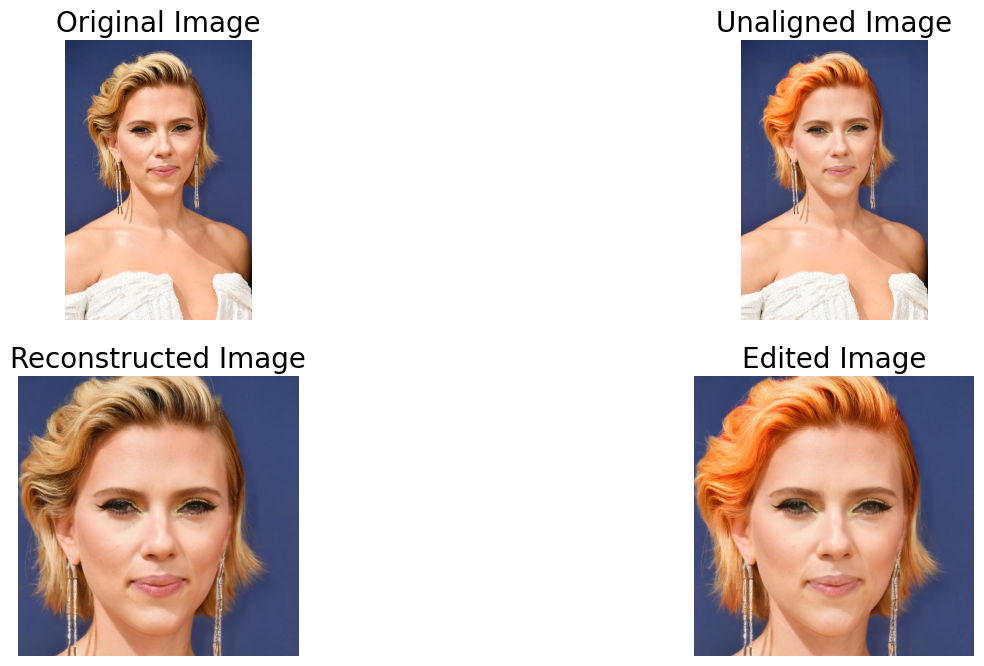

In [33]:
#@title Fire hair editing { display-mode: "form" }
neutral_prompt = "face with hair"
target_prompt = "face with fire hair"
disentanglement = 0.1
runner.edit(
    orig_img_pth="notebook/images/scarlet.jpg",
    editing_name=f"styleclip_global_{neutral_prompt}_{target_prompt}_{disentanglement}",
    edited_power=9,
    save_pth="editing_res/scarlet/scarlet.jpg",
    align=True,
    save_inversion=True,
    use_mask=True,
    mask_trashold=0.095
)

plot_edited_images(
    orig_pth="notebook/images/scarlet.jpg",
    edited_pth="editing_res/scarlet/scarlet.jpg",
    inversion_pth="editing_res/scarlet/scarlet_inversion.jpg",
    unaligned_path="editing_res/scarlet/scarlet_unaligned.jpg"
)

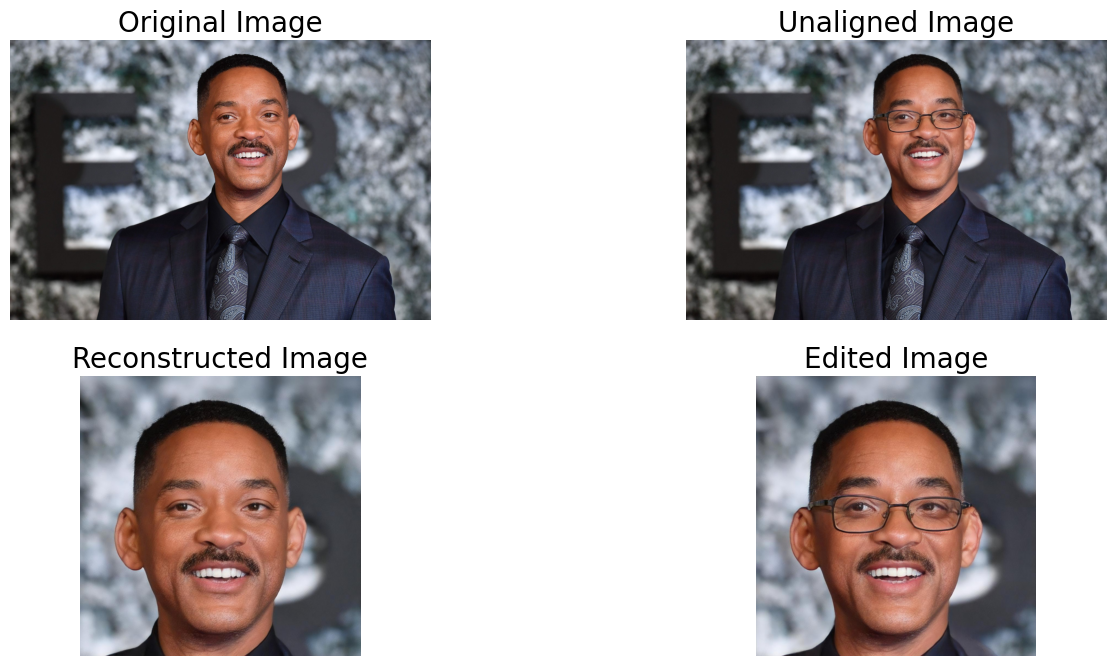

In [28]:
#@title Add glasses editing { display-mode: "form" }
runner.edit(
    orig_img_pth="notebook/images/smith.jpg",
    editing_name="fs_glasses",
    edited_power=10,
    save_pth="editing_res/smith/smith.jpg",
    align=True,
    save_inversion=True
)

plot_edited_images(
    orig_pth="notebook/images/smith.jpg",
    edited_pth="editing_res/smith/smith.jpg",
    inversion_pth="editing_res/smith/smith_inversion.jpg",
    unaligned_path="editing_res/smith/smith_unaligned.jpg"
)

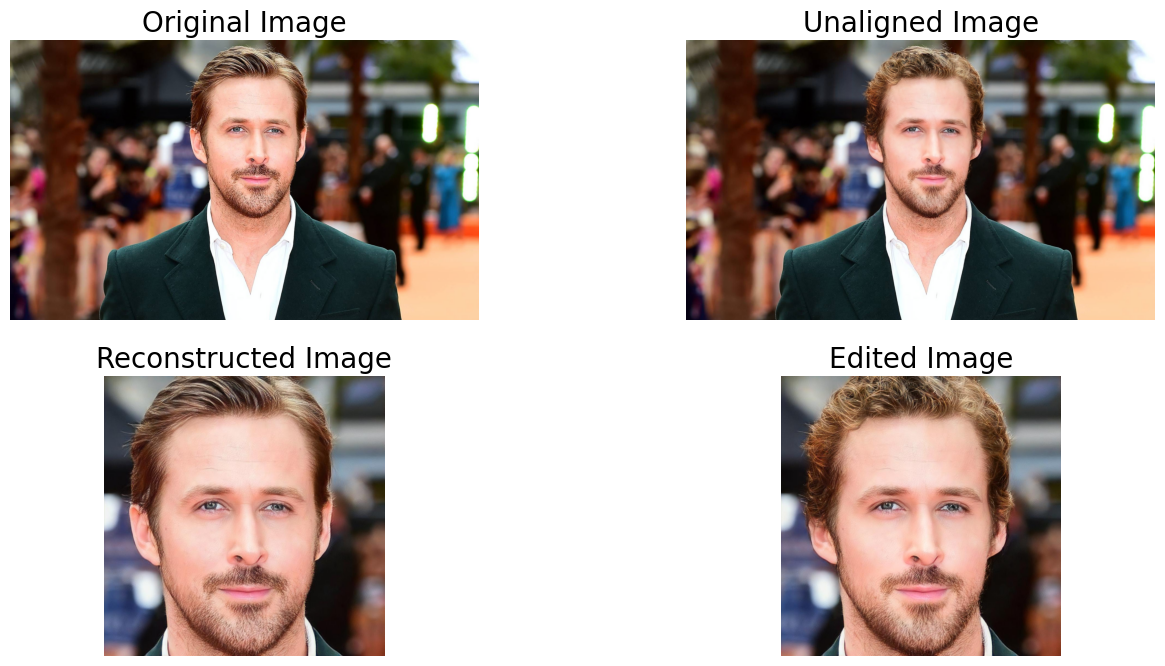

In [29]:
#@title Curly hairstyle editing { display-mode: "form" }
runner.edit(
    orig_img_pth="notebook/images/gosling.jpg",
    editing_name="curly_hair",
    edited_power=0.10,
    save_pth="editing_res/gosling/gosling.jpg",
    align=True,
    use_mask=True,
    save_inversion=True
)

plot_edited_images(
    orig_pth="notebook/images/gosling.jpg",
    edited_pth="editing_res/gosling/gosling.jpg",
    inversion_pth="editing_res/gosling/gosling_inversion.jpg",
    unaligned_path="editing_res/gosling/gosling_unaligned.jpg"
)

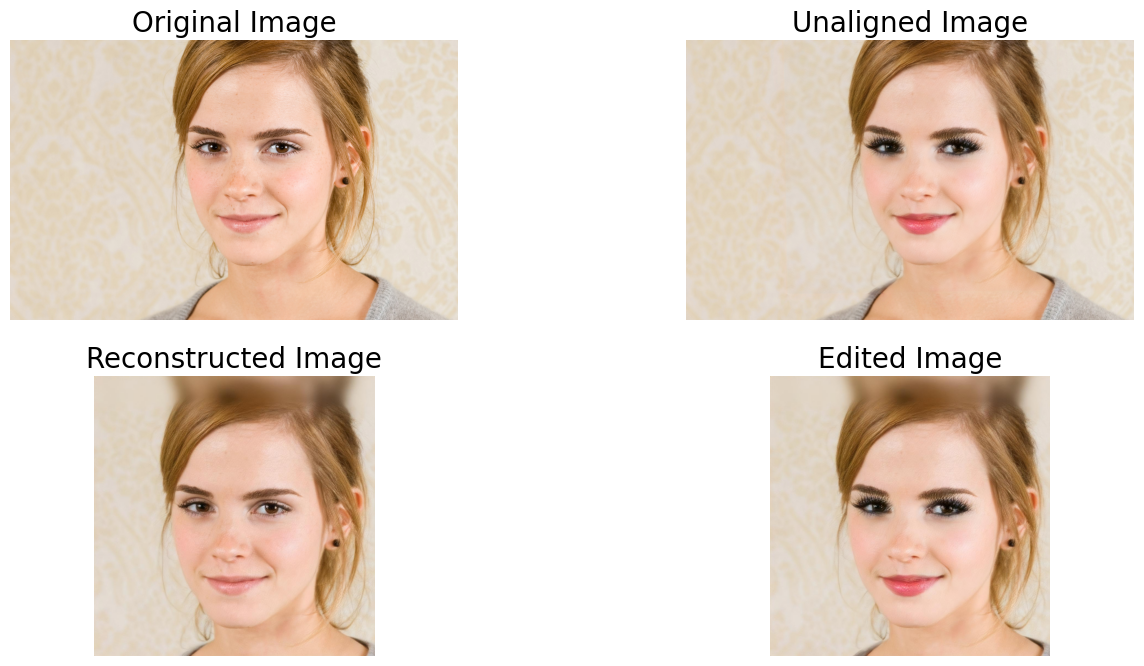

In [30]:
#@title Add makeup editing { display-mode: "form" }
neutral_prompt = "woman face"
target_prompt = "woman face with makeup and lipstick"
disentanglement = 0.11
runner.edit(
    orig_img_pth="notebook/images/watson.jpeg",
    editing_name=f"styleclip_global_{neutral_prompt}_{target_prompt}_{disentanglement}",
    edited_power=10,
    save_pth="editing_res/watson/watson.jpg",
    align=True,
    save_inversion=True
)

plot_edited_images(
    orig_pth="notebook/images/watson.jpeg",
    edited_pth="editing_res/watson/watson.jpg",
    inversion_pth="editing_res/watson/watson_inversion.jpg",
    unaligned_path="editing_res/watson/watson_unaligned.jpg"
)

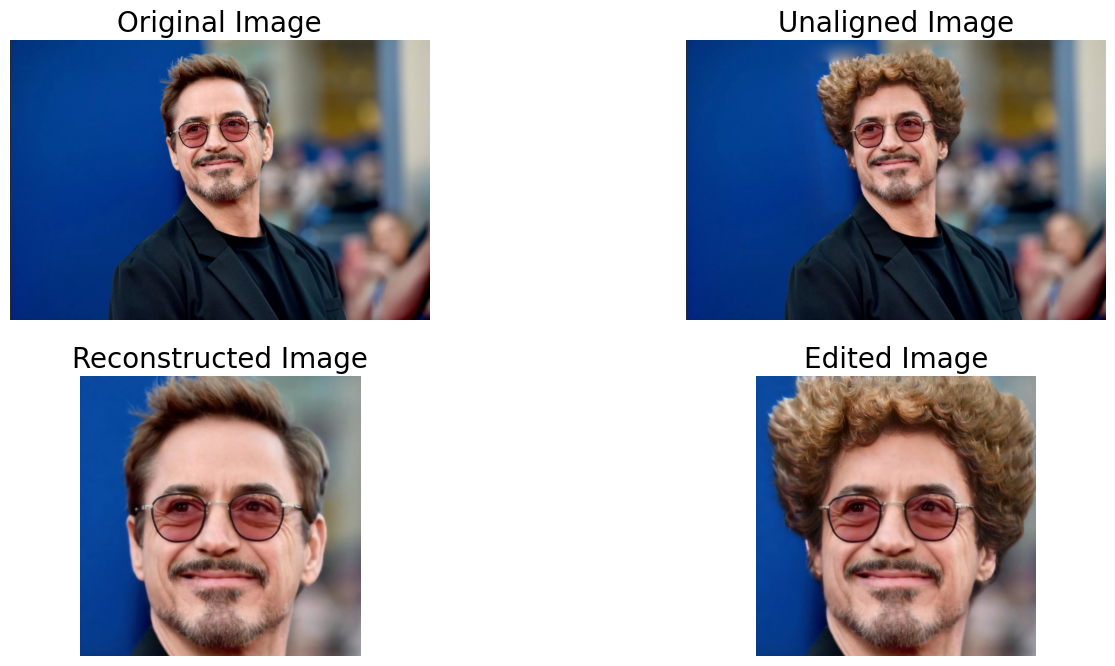

In [31]:
#@title Afro hairstyle editing { display-mode: "form" }
neutral_prompt = "face"
target_prompt = "face with curly afro"
disentanglement = 0.14
runner.edit(
    orig_img_pth="notebook/images/robert.png",
    editing_name=f"styleclip_global_{neutral_prompt}_{target_prompt}_{disentanglement}",
    edited_power=5,
    save_pth="editing_res/robert/robert.jpg",
    align=True,
    use_mask=True,
    mask_path="notebook/images/robert_aligned_mask.jpg",
    save_inversion=True,
)

plot_edited_images(
    orig_pth="notebook/images/robert.png",
    edited_pth="editing_res/robert/robert.jpg",
    inversion_pth="editing_res/robert/robert_inversion.jpg",
    unaligned_path="editing_res/robert/robert_unaligned.jpg"
)

## Inference playground on gif images

Found 1 faces, getting the largest
Save aligned image to editing_res/dicaprio/dicaprio_aligned.jpg
Prepearing mask


/content/StyleFeatureEditor/models/farl/farl.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(


Done
Use mask from editing_res/dicaprio/dicaprio_aligned_mask.jpg


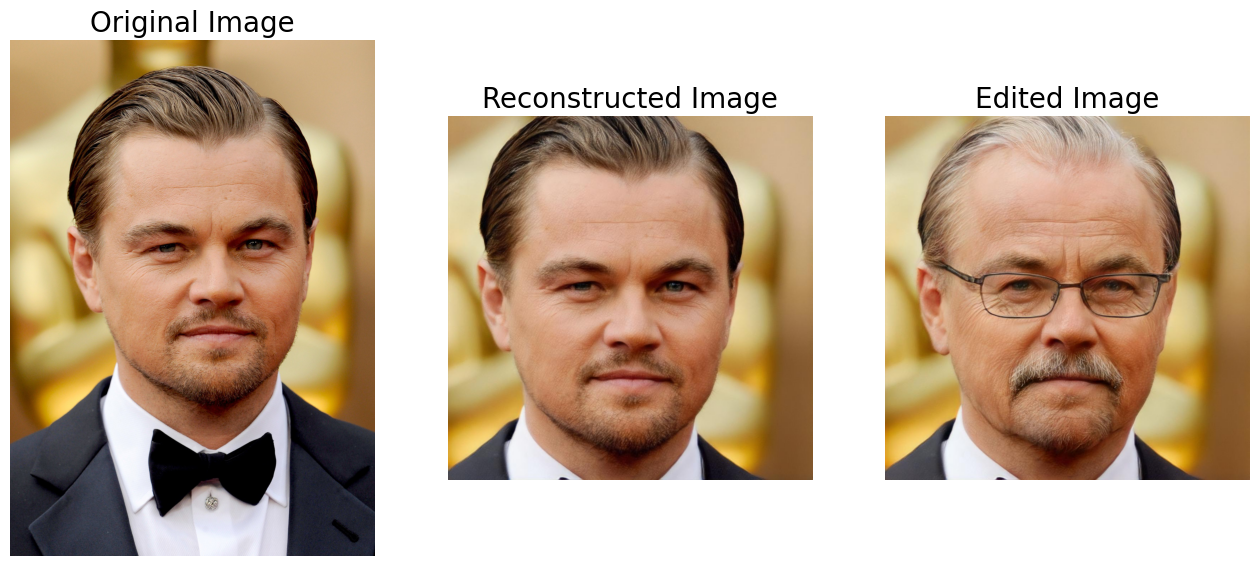

In [34]:
#@title Increase age { display-mode: "form" }
# @markdown Inference params
Image_path = "assets/dicaprio.png"              # @param {type:"string"}
Editing_name = "age"
Editing_power = 8.5                             # @param {type:"slider", min:0, max:8.5, step:0.1}
Save_path = "editing_res/dicaprio/dicaprio.jpg" # @param {type:"string"}
Align_image = True
Use_mask = True
Default_mask_trashold = 0.99
Mask_path = None
Show_inversion_result = True
Show_e4e_approximation = False

runner.edit(
    orig_img_pth=Image_path,
    editing_name=Editing_name,
    edited_power=Editing_power,
    save_pth=Save_path,
    align=Align_image,
    save_inversion=Show_inversion_result,
    save_e4e=Show_e4e_approximation,
    use_mask=Use_mask,
    mask_trashold=Default_mask_trashold,
    mask_path=Mask_path,
)

Save_path = Path(Save_path)
inversion_pth = None
e4e_inv_pth = None
e4e_edit_pth = None

if Show_inversion_result:
  inversion_pth = Save_path.parents[0] / (Save_path.stem + "_inversion.jpg")

if Show_e4e_approximation:
  e4e_inv_pth = Save_path.parents[0] / (Save_path.stem + "_e4e_inversion.jpg")
  e4e_edit_pth = Save_path.parents[0] / (Save_path.stem + "_e4e_edit.jpg")

plot_edited_images(
    orig_pth=Image_path,
    edited_pth=Save_path,
    inversion_pth=inversion_pth,
    e4e_inv_pth=e4e_inv_pth,
    e4e_edit_pth=e4e_edit_pth
)

Found 1 faces, getting the largest
Save aligned image to editing_res/keanu/keanu_aligned.jpg


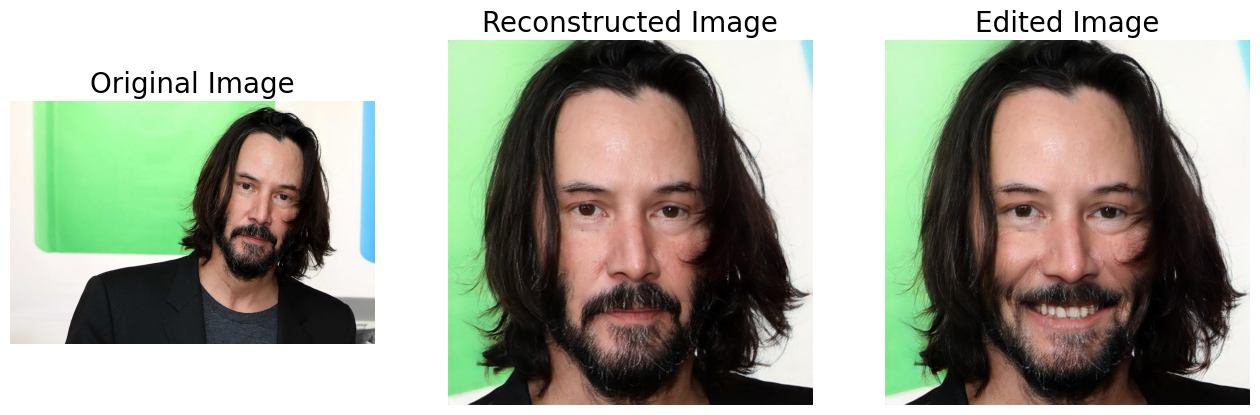

In [18]:
#@title Add smile { display-mode: "form" }
# @markdown Inference params
Image_path = "assets/keanu.jpeg"                # @param {type:"string"}
Editing_name = "smile"
Editing_power = 3                               # @param {type:"slider", min:0, max:3, step:0.02}
Save_path = "editing_res/keanu/keanu.jpg"       # @param {type:"string"}
Use_mask = False
Align_image = True
Default_mask_trashold = 0.99
Mask_path = None
Show_inversion_result = True
Show_e4e_approximation = False

runner.edit(
    orig_img_pth=Image_path,
    editing_name=Editing_name,
    edited_power=Editing_power,
    save_pth=Save_path,
    align=Align_image,
    save_inversion=Show_inversion_result,
    save_e4e=Show_e4e_approximation,
    use_mask=Use_mask,
    mask_trashold=Default_mask_trashold,
    mask_path=Mask_path,
)

Save_path = Path(Save_path)
inversion_pth = None
e4e_inv_pth = None
e4e_edit_pth = None

if Show_inversion_result:
  inversion_pth = Save_path.parents[0] / (Save_path.stem + "_inversion.jpg")

if Show_e4e_approximation:
  e4e_inv_pth = Save_path.parents[0] / (Save_path.stem + "_e4e_inversion.jpg")
  e4e_edit_pth = Save_path.parents[0] / (Save_path.stem + "_e4e_edit.jpg")

plot_edited_images(
    orig_pth=Image_path,
    edited_pth=Save_path,
    inversion_pth=inversion_pth,
    e4e_inv_pth=e4e_inv_pth,
    e4e_edit_pth=e4e_edit_pth
)

Found 1 faces, getting the largest
Save aligned image to editing_res/potter/potter_aligned.jpg


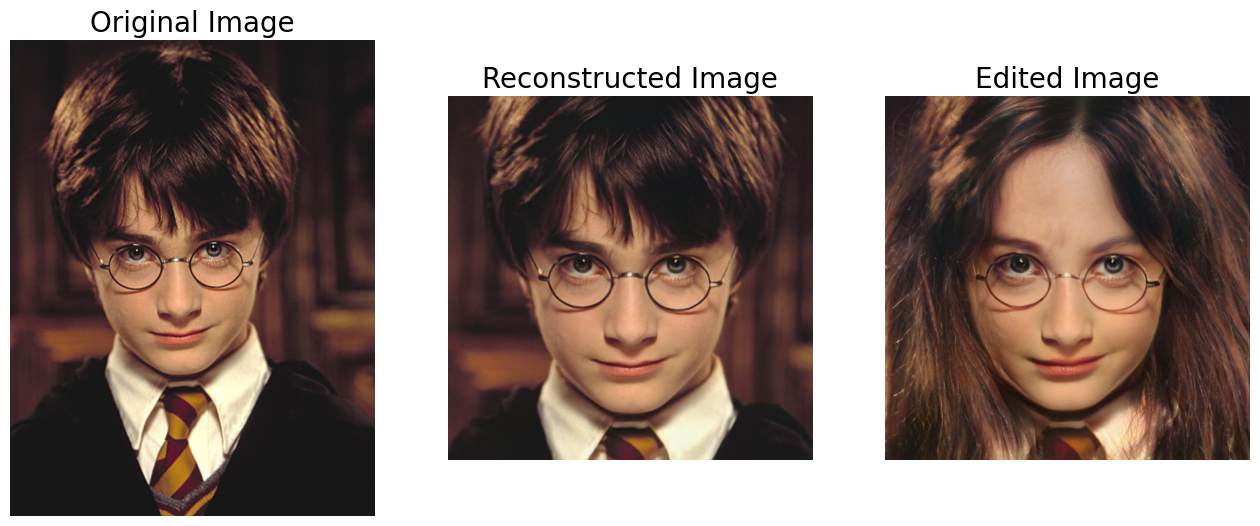

In [19]:
#@title Change gender { display-mode: "form" }

# @markdown Inference params
Image_path = "assets/potter.jpg"                # @param {type:"string"}

neutral_prompt = "man face with short hair with bang"
target_prompt = "woman face with red lipstick and long hair without bang"
disentanglement = 0.1
Editing_name = f"styleclip_global_{neutral_prompt}_{target_prompt}_{disentanglement}"

Editing_power = 6                               # @param {type:"slider", min:0, max:6, step:0.02}
Save_path = "editing_res/potter/potter.jpg"     # @param {type:"string"}

Align_image = True
Use_mask = False
Default_mask_trashold = 0.999
Mask_path = None
Show_inversion_result = True
Show_e4e_approximation = False


runner.edit(
    orig_img_pth=Image_path,
    editing_name=Editing_name,
    edited_power=Editing_power,
    save_pth=Save_path,
    align=Align_image,
    save_inversion=Show_inversion_result,
    save_e4e=Show_e4e_approximation,
    use_mask=Use_mask,
    mask_trashold=Default_mask_trashold,
    mask_path=Mask_path,
)

Save_path = Path(Save_path)
inversion_pth = None
e4e_inv_pth = None
e4e_edit_pth = None

if Show_inversion_result:
  inversion_pth = Save_path.parents[0] / (Save_path.stem + "_inversion.jpg")

if Show_e4e_approximation:
  e4e_inv_pth = Save_path.parents[0] / (Save_path.stem + "_e4e_inversion.jpg")
  e4e_edit_pth = Save_path.parents[0] / (Save_path.stem + "_e4e_edit.jpg")

plot_edited_images(
    orig_pth=Image_path,
    edited_pth=Save_path,
    inversion_pth=inversion_pth,
    e4e_inv_pth=e4e_inv_pth,
    e4e_edit_pth=e4e_edit_pth
)

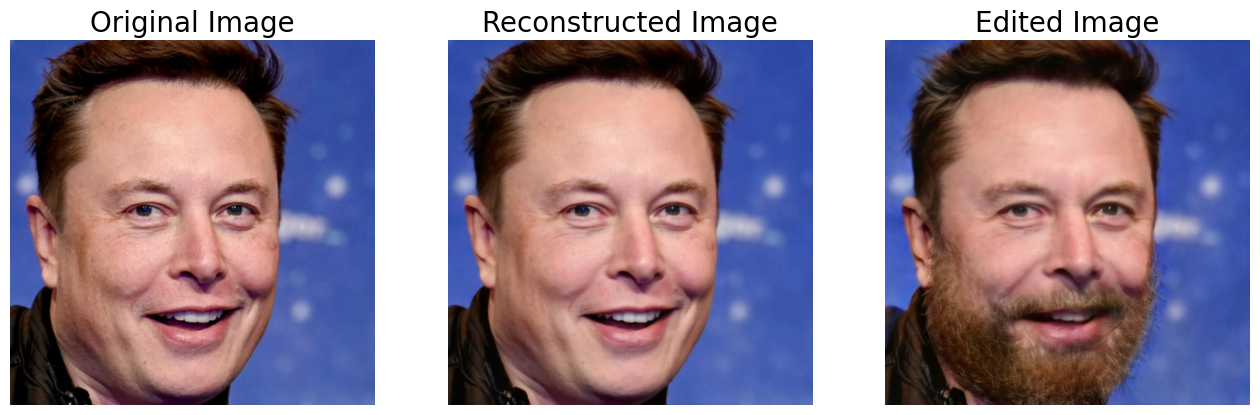

In [20]:
#@title Add thick beard editing { display-mode: "form" }
# @markdown Inference params
Image_path = "assets/mask.jpg"                  # @param {type:"string"}

neutral_prompt = "shaved face"
target_prompt = "face with a dark beard and stubble"
disentanglement = 0.1
First_editing_name = f"styleclip_global_{neutral_prompt}_{target_prompt}_{disentanglement}"

Beard_editing_power = 10                        # @param {type:"slider", min:0, max:10, step:0.05}
Second_editing_name = "sideburns"
Sideburns_editing_power = 3                     # @param {type:"slider", min:0, max:3, step:0.01}
Save_path = "editing_res/mask/mask.jpg"         # @param {type:"string"}

Align_image = False
Use_mask = False
Default_mask_trashold = 0.99
Mask_path = None
Show_inversion_result = True
Show_e4e_approximation = False

Save_path = Path(Save_path)
tmp_save = Save_path.parents[0] / (Save_path.stem + "_tmp.jpg")

runner.edit(
    orig_img_pth=Image_path,
    editing_name=First_editing_name,
    edited_power=Beard_editing_power,
    save_pth=tmp_save,
    align=Align_image,
    save_inversion=Show_inversion_result,
    save_e4e=Show_e4e_approximation,
    use_mask=Use_mask,
    mask_trashold=Default_mask_trashold,
    mask_path=Mask_path,
)

runner.edit(
    orig_img_pth=tmp_save,
    editing_name=Second_editing_name,
    edited_power=-Sideburns_editing_power,
    save_pth=Save_path,
    align=False,
    save_inversion=False,
    save_e4e=Show_e4e_approximation,
    use_mask=Use_mask,
    mask_trashold=Default_mask_trashold,
    mask_path=Mask_path,
)

inversion_pth = None
e4e_inv_pth = None
e4e_edit_pth = None

if Show_inversion_result:
  inversion_pth = Save_path.parents[0] / (Save_path.stem + "_tmp_inversion.jpg")

if Show_e4e_approximation:
  e4e_inv_pth = Save_path.parents[0] / (Save_path.stem + "_e4e_inversion.jpg")
  e4e_edit_pth = Save_path.parents[0] / (Save_path.stem + "_e4e_edit.jpg")

plot_edited_images(
    orig_pth=Image_path,
    edited_pth=Save_path,
    inversion_pth=inversion_pth,
    e4e_inv_pth=e4e_inv_pth,
    e4e_edit_pth=e4e_edit_pth
)

## Template for your editing

In [ ]:
runner.available_editings()

Found 1 faces, getting the largest
Save aligned image to editing_res/dicaprio/dicaprio_aligned.jpg
Prepearing mask
Done
Use mask from editing_res/dicaprio/dicaprio_aligned_mask.jpg


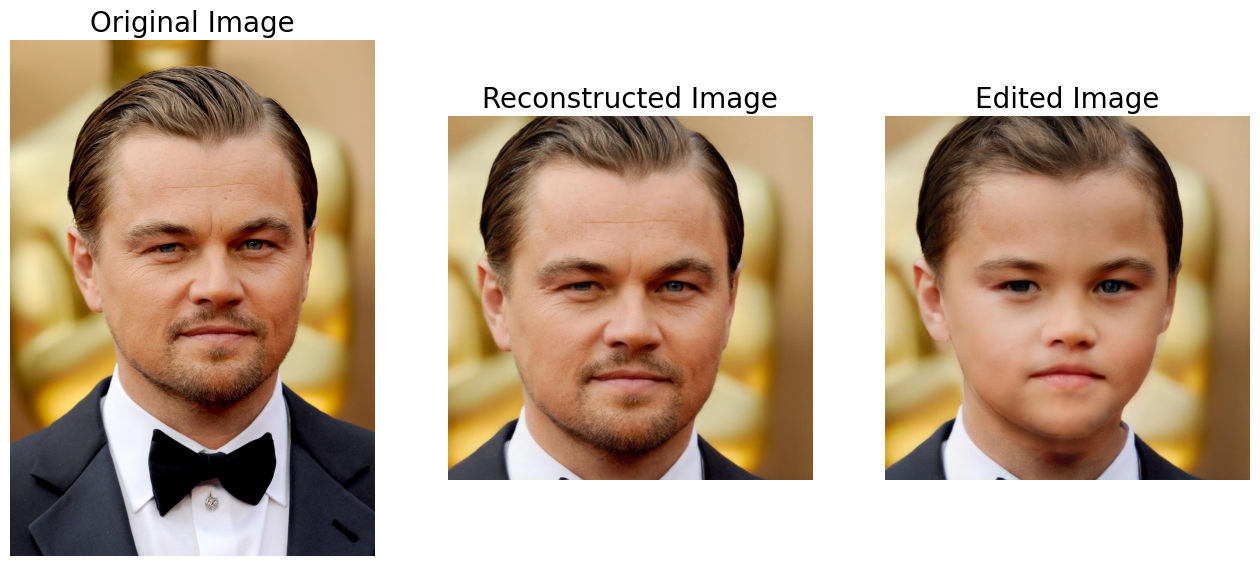

In [ ]:
#@title Inference Playground { display-mode: "form" }
# @markdown Inference params
Image_path = "assets/dicaprio.png"              # @param {type:"string"}
Editing_name = "age"                            # @param {type:"string"}
Editing_power = -8                             # @param {type:"slider", min:-10, max:10, step:0.01}
Save_path = "editing_res/dicaprio/dicaprio.jpg" # @param {type:"string"}
Align_image = True                              # @param {type:"boolean"}
Use_mask = True                                 # @param {type:"boolean"}
Default_mask_trashold = 0.99                    # @param {type:"slider", min:0, max:1, step:0.01}
Mask_path = None                                # @param {type:"string"}
Show_inversion_result = True                    # @param {type:"boolean"}
Show_e4e_approximation = False                  # @param {type:"boolean"}

runner.edit(
    orig_img_pth=Image_path,
    editing_name=Editing_name,
    edited_power=Editing_power,
    save_pth=Save_path,
    align=Align_image,
    save_inversion=Show_inversion_result,
    save_e4e=Show_e4e_approximation,
    use_mask=Use_mask,
    mask_trashold=Default_mask_trashold,
    mask_path=Mask_path,
)

Save_path = Path(Save_path)
inversion_pth = None
e4e_inv_pth = None
e4e_edit_pth = None

if Show_inversion_result:
  inversion_pth = Save_path.parents[0] / (Save_path.stem + "_inversion.jpg")

if Show_e4e_approximation:
  e4e_inv_pth = Save_path.parents[0] / (Save_path.stem + "_e4e_inversion.jpg")
  e4e_edit_pth = Save_path.parents[0] / (Save_path.stem + "_e4e_edit.jpg")

plot_edited_images(
    orig_pth=Image_path,
    edited_pth=Save_path,
    inversion_pth=inversion_pth,
    e4e_inv_pth=e4e_inv_pth,
    e4e_edit_pth=e4e_edit_pth
)

## Making gif for your editing

In [ ]:
#@title GIF Creator { display-mode: "form" }
# @markdown Inference params
Image_path = "assets/dicaprio.png"              # @param {type:"string"}
Editing_name = "age"                            # @param {type:"string"}
Start_editing_power = 0                         # @param {type:"slider", min:-10, max:10, step:0.01}
End_editing_power = 8.5                         # @param {type:"slider", min:-10, max:10, step:0.01}
Path_to_save_dir = "editing_res/dicaprio_gif/"  # @param {type:"string"}
Gif_type = "gif"                                # @param ["webp", "gif"]
N_frames = 120                                  # @param {type:"integer"}
Gif_size = 256                                  # @param {type:"integer"}
Align_image = True                              # @param {type:"boolean"}
Use_mask = True                                # @param {type:"boolean"}
Default_mask_trashold = 0.99                    # @param {type:"slider", min:0, max:1, step:0.01}
Mask_path = None                                # @param {type:"string"}

powers = np.linspace(Start_editing_power, End_editing_power, N_frames)

Path_to_save_dir = Path(Path_to_save_dir)
if Align_image or Use_mask:
  tmp_save_pth = Path_to_save_dir / "tmp.jpg"
  runner.edit(
      orig_img_pth=Image_path,
      editing_name=Editing_name,
      edited_power=0,
      save_pth=tmp_save_pth,
      align=Align_image,
      save_inversion=False,
      save_e4e=False,
      use_mask=Use_mask,
      mask_trashold=Default_mask_trashold,
      mask_path=Mask_path,
  )

  if Align_image:
    Image_path =  Path_to_save_dir / "tmp_aligned.jpg"

  if Use_mask and Mask_path is None and not Align_image:
    Mask_path = Path_to_save_dir / "tmp_mask.jpg"

  if Use_mask and Mask_path is None and Align_image:
    Mask_path = Path_to_save_dir / "tmp_aligned_mask.jpg"

print("Start creating frames")

frames = []
for power in tqdm(powers):
  save_pth = Path_to_save_dir / f"frame.jpg"
  runner.edit(
      orig_img_pth=Image_path,
      editing_name=Editing_name,
      edited_power=power,
      save_pth=save_pth,
      align=False,
      save_inversion=False,
      save_e4e=False,
      use_mask=Use_mask,
      mask_path=Mask_path,
  )
  frames.append(Image.open(save_pth).resize((Gif_size, Gif_size)))

frames = [frames[0]] * 30 + frames + [frames[-1]] * 30
frames = frames + frames[::-1]

print("Frames creation complete, start creating animation")

frames[0].save(
    Path_to_save_dir / f"result.{Gif_type}",
    save_all=True,
    append_images=frames[1:],
    duration=30,
    loop=0,
)

print("Done")
